# Using CNN analysis for use in Species ID in Ecological Datasets

A script to differentiate between the 5 flower species of the tf_flowers dataset


Number of classes = 5


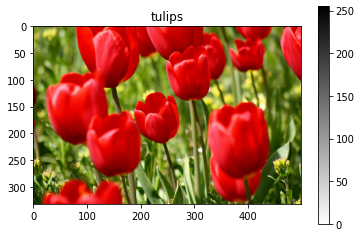

In [91]:
# import required packages and databases
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# load and split tensorflow 'tf_flowers' dataset into training and validation datasets
(train_ds, val_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)

# check the number of classes to identify (how many kinds of flower are in the dataset):
num_classes = metadata.features['label'].num_classes
print("Number of classes =", num_classes)

# retreiving an image example:
get_label_name = metadata.features['label'].int2str
image, label = next(iter(train_ds))
_ = plt.title(get_label_name(label))
_ = plt.imshow(image, cmap=plt.cm.binary)
_ = plt.colorbar()


**Reformatting images and creating batches**


In [120]:
# check the image shape data in the unmodified dataset
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break 
# Shows only 3 columns of data, needs one more column to fit model
# Additionally, the images in the dataset are of different sizes

# Resize image RGB data to 0-1 scale instead of 0-255,
# and resize images to measure 224 x 224 pixels
IMAGE_RES = 224 # Change IMAGE_RES to alter image size (smaller images reduce model run time)
def normalize_img(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label

#To reconfigure the data and make training and validation batches size 32
batch_size = 32
train_batches = train_ds.shuffle(2569//4).map(normalize_img).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_batches = val_ds.map(normalize_img).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Print new shape of data with extra column
print(train_batches) 
print(val_batches)
# Print RGB values - should now be between 0 and 1
print(np.min(first_image), np.max(first_image)) 
print(np.min(first_image), np.max(first_image))

(333, 500, 3)
()
<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>
<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>
0.8745099 1.0
0.8745099 1.0


**Building the model:**

In [126]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation='relu'), # second convolution and pooling layers 
  tf.keras.layers.MaxPooling2D(), 
  tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation='relu'), # second convolution and pooling layers 
  tf.keras.layers.MaxPooling2D(), 
  tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation='relu'), # third convolution and pooling layers 
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'), # Adds a dense layer of 128 neurons
  tf.keras.layers.Dropout(0.4), # Adds a dropout layer, to avoid overfitting
  tf.keras.layers.Dense(num_classes, activation='softmax') # Adds a final layer with the number of classes (5)
])

**Fitting and Running the Model:**

In [127]:
model.compile(
  loss="sparse_categorical_crossentropy",
  optimizer='adam', metrics=['accuracy'])

epochs = 5 # Increase the number of epochs and see what affect this has on model accuracy of predicitons.

model_fit=model.fit(
  train_batches,
  validation_data=val_batches,
  epochs=epochs
)

model_fit # Current model run tim with 5 epochs is around 15 minutes.


Epoch 1/5
81/81 [==============================] - 155s 2s/step - loss: 1.4197 - accuracy: 0.3920 - val_loss: 1.1589 - val_accuracy: 0.5313
Epoch 2/5
81/81 [==============================] - 155s 2s/step - loss: 1.1387 - accuracy: 0.5527 - val_loss: 1.0614 - val_accuracy: 0.5886
Epoch 3/5
81/81 [==============================] - 153s 2s/step - loss: 0.9572 - accuracy: 0.6205 - val_loss: 0.9742 - val_accuracy: 0.6276
Epoch 4/5
81/81 [==============================] - 153s 2s/step - loss: 0.8026 - accuracy: 0.6890 - val_loss: 0.9921 - val_accuracy: 0.6394
Epoch 5/5
81/81 [==============================] - 153s 2s/step - loss: 0.6559 - accuracy: 0.7485 - val_loss: 1.0729 - val_accuracy: 0.6049


Current model returns a successful ID rate of 0.63


**Plotting the model 'learning' graph to observe accuracy through time**

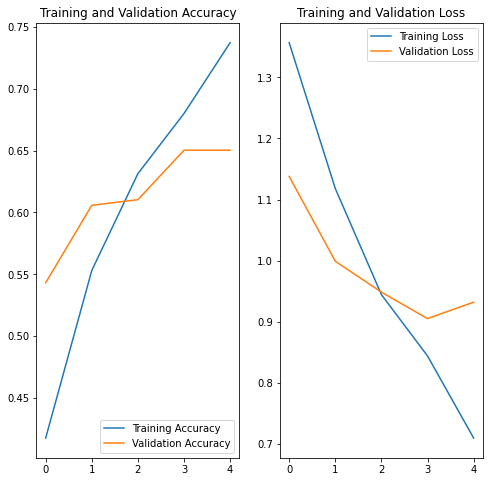

In [123]:
acc = model_fit.history['accuracy']
val_acc = model_fit.history['val_accuracy']
loss = model_fit.history['loss']
val_loss = model_fit.history['val_loss']
epochs_range = 5
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Creating another batch of images from the tf_flower dataset, and using the trained model to predict flower IDs

In [128]:
class_names = np.array(metadata.features['label'].names)
image_batch, label_batch = next(iter(train_batches))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

32

Finally, visualise the predictions of the model

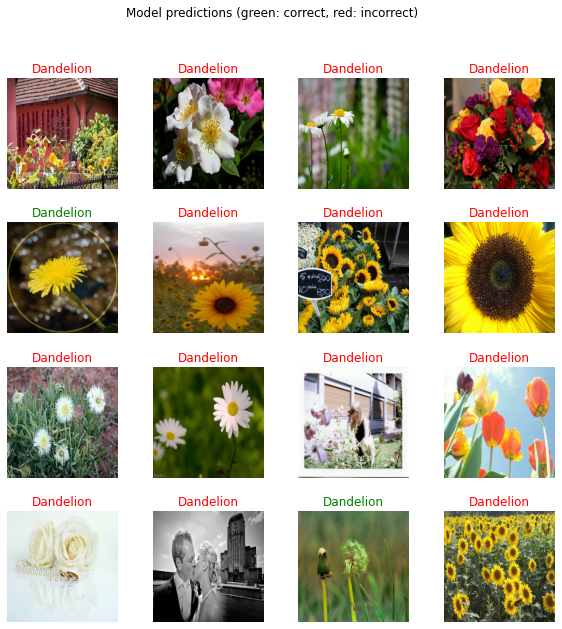

In [117]:
plt.figure(figsize=(10,10)) 
for n in range(16): # Increase the range to see more image results (may need to also increase figsize in the previous line, if this becomes too crowded)
    plt.subplot(4,4,n+1) # alter the dimensions of the grid plot
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    color = "green" if predicted_ids[n] == label_batch[n] else "red" # colour labels according to correct ID by model, or not
    plt.title(predicted_class_names[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)") # Title